<br>

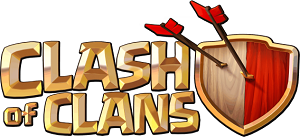

<br>

<br>

<center><h1>Dataset Creation - Clash of Clans Troop Info</h1></center>


## Introduction

This notebook goes through the process of dataset creation with the Clash of Clans wiki page as our source of information. We're going to heavily utilize **BeautifulSoup** library to scrape the wiki pages and **pandas** library to organize the acquired information.

We'll be walking through:
1. **Getting the Data** - we will be scraping the data from the CoC's wiki pages
2. **Organize acquired Data** - we'll use pandas to store the data

The output of this notebook are a collection of clean, organized data stored in Dataframe object

<br>

### Import required libraries

In [1]:
import requests, json, os, glob, re
import pandas as pd
from bs4 import BeautifulSoup

## 1. Getting the Data

Our goal is to create a dataset of CoC's troop info. There are tons of troops in Clash of Clans so first we need to list them all. Luckily https://clashofclans.fandom.com/wiki/Army page has a table that list all of troop of Clash of Clans, we'll start our data collecting from there.

In [2]:
html_text = requests.get('https://clashofclans.fandom.com/wiki/Army').content
soup = BeautifulSoup(html_text)

In [3]:
tables = soup.find_all('table', class_ = 'wikitable')

### 1.1. Scrape List of Troop

In [4]:
troop_url_dict = {}

for table in tables:
    base = table.select_one('tr:first-child th').text.strip()
    row_cnt = len(table.find_all('tr'))
    troop_url_dict[base] = {}
    
    for i in range(2, row_cnt+1):
        class_ = table.select_one(f'tr:nth-child({i}) td').text.strip()
        troops = table.select(f'tr:nth-child({i}) td:nth-child(2) a')
        troop_url_dict[base][class_] = {}
        
        for troop in troops:
            troop_url_dict[base][class_][troop.text] = troop.get('href')

In [5]:
### Save dict as json file

with open('json/scrape/coc/troop_url.json', 'w') as file:
    json.dump(troop_url_dict, file)

In [6]:
### Open json file and save to variable

with open('json/scrape/coc/troop_url.json', 'r') as file:
    army_url_dict = json.load(file)

In [7]:
BASE_URL = 'https://clashofclans.fandom.com'

In [8]:
def fetch_detail_info(troop_url, selector='table.wikitable.floatheader'):
    """
        Fetch the detail info of troops
        Take dict troop_name:url pair as parameter
    """
    army_detail = {}
    not_found = {}
    
    for troop in troop_url:
        troop_html = requests.get(f'{BASE_URL}{troop_url[troop]}').content
        soup = BeautifulSoup(troop_html)
        info_table = soup.select(selector)
        
        if info_table != []:    
            troop_attr = []
            ## fetch troop's attributes
            for th in info_table[0].select('th'):
                ## we only need the first table's th in the list
                troop_attr.append(th.text.replace('\n', ''))
            
            info = {}
            ## fetch troop's detailed info
            for item in info_table:
                for i, attr in enumerate(troop_attr):
                    info[attr] = [i.text.replace('\n', '') for i in item.select(f'td:nth-child({i+1})')]
                    ## we only need the first item so we break the loop after 1 iter
                break
            army_detail[troop] = info
        else:
            not_found[troop] = troop_url[troop]
    
    return army_detail, not_found

### 1.2. Scrape Army Detail Info

Now that we have our list of Troop, we can proceed to collect each of the troop's detailed info. We then save the acquired info into json files.

In [ ]:
## Dict to store all troop:url pair of not found troop info
not_found_dict = {}

for base in army_url_dict:
    not_found_dict[base] = {}
    for class_ in army_url_dict[base]:
        not_found_dict[base][class_] = {}
        army_detail, not_found = fetch_detail_info(army_url_dict[base][class_])
        
        if army_detail != {}:
            ## save acquired info to json file
            filename = f'json/scrape/coc/army_detail/{base}/{class_}.json'
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, 'w') as file:
                json.dump(army_detail, file)
                
        if not_found != {}:
            not_found_dict[base][class_] = not_found
        else:
            del not_found_dict[base][class_]


## save not_found_dict to a json file
with open('json/scrape/coc/army_detail/not_found.json', 'w') as file:
    json.dump(not_found_dict, file)

It seems like we failed to fetch the info of some troops, but it doesn't mean the info is not exist. It can be caused by the difference of HTML structure between troop pages.

In [9]:
with open('json/scrape/coc/army_detail/not_found.json', 'r') as file:
    not_found_dict = json.load(file)

In [38]:
for base in not_found_dict:
    print(base)
    for class_ in not_found_dict[base]:
        print(f'⤷-{class_}')
        print(f'   ⤷-{list(not_found_dict[base][class_].keys())}')
    print()

Home Village Army
⤷-Dark Elixir Troops
   ⤷-['Skeleton', 'Lava Pup']
⤷-Super Troops
   ⤷-['Big Boy', 'Ice Pup']
⤷-Elixir Spells
   ⤷-['Jump Spell', 'Freeze Spell', 'Clone Spell', 'Invisibility Spell', 'Recall Spell']
⤷-Dark Spells
   ⤷-['Poison Spell', 'Earthquake Spell', 'Haste Spell', 'Skeleton Spell', 'Skeleton', 'Bat Spell', 'Bat']
⤷-Siege Machines
   ⤷-['Wall Wrecker', 'Battle Blimp', 'Stone Slammer', 'Siege Barracks', 'Log Launcher', 'Flame Flinger', 'Battle Drill']
⤷-Pets
   ⤷-['Frostmite']

Builder Base Army
⤷-Troops
   ⤷-['Bat', 'Skeleton']

Clan Capital Army
⤷-Troops
   ⤷-['Skeleton']
⤷-Spells
   ⤷-['Healing Spell', 'Jump Spell', 'Lightning Spell', 'Frost Spell', 'Rage Spell']



#### Create Dataframes of army detail

In [ ]:
rootdir = "json/scrape/coc/army_detail"
army_detail_df = {}

for path in glob.glob(f'{rootdir}/*/'):
    ## path = json/scrape/coc/army_detail\Builder Base Army\
    base = re.search(r'\\(.*?)\\', path).group(1)
    army_detail_df[base] = {}
    for filename in glob.glob(os.path.join(path, '*.json')):
        ## filename = json/scrape/coc/army_detail\Builder Base Army\Heroes.json
        class_ = re.search(r'Army\\(.+?).json', filename).group(1)
        army_detail_df[base][class_] = {}
        with open(os.path.join(os.getcwd(), filename), 'r') as file:
            army_detail = json.load(file)
            for army in army_detail:
                try:
                    army_detail_df[base][class_][army] = pd.DataFrame.from_dict(army_detail[army])
                except:
                    print(f'{base} : {class_} : {army}')

In [ ]:
army_detail_df['Home Village Army']['Elixir Troops']['Electro Dragon']

In [ ]:
path = "json/scrape/coc/army_detail"

for filename in glob.glob(os.path.join(path, '*.json')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        print(filename)

In [ ]:
troop_info = requests.get(f'{BASE_URL}/wiki/Barbarian_King').content
soup = BeautifulSoup(troop_info)

info_table = soup.select('table.wikitable.floatheader')

In [ ]:
troop_attr = []

for th in info_table[0].select('th'):
    troop_attr.append(th.text.replace('\n', ''))

In [ ]:
troop_attr

In [ ]:
info = {}
for item in info_table:
    for i, atr in enumerate(troop_attr):
        info[atr] = [i.text.replace('\n', '') for i in item.select(f'td:nth-child({i+1})')]
    break